# Sætter partier og regioner ind i G og rewriter filen

In [1]:
import networkx as nx
import pickle
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import re
from fa2 import ForceAtlas2


In [2]:
data=pd.read_csv("danish_politkere_twitter2.csv")

In [3]:
data.groupby('Party').count()

,Names,Twittername,Region
Party,,,
Alternativet,4,4,4
Dansk Folkeparti,21,21,21
Det Konservative Folkeparti,22,22,22
Det Radikale Venstre,1,1,1
Enhedslisten,23,23,23
Government,14,14,14
Inuit Ataqatigiit,1,1,1
Liberal Alliance,7,7,7
Nye Borgerlige,4,4,4


In [4]:
len(data.index)

651

In [5]:
G = nx.read_gpickle("second_network_w_weights_listversion_wrealnames_v2.gpickle")

In [6]:
G.number_of_nodes()

561

In [7]:
def pre_check():
    nodes = G.nodes()
    count=0
    to_remove = [] 
    for node in nodes:
        if node in data.values:
            count+=1
        else:
            print(node + " will be removed")
            to_remove.append(node)
    for node in to_remove:
        G.remove_node(node)
    return len(to_remove)

print("Removing " +str(pre_check()) + " nodes")

Birgitte2012 will be removed
MFVMin will be removed
SassLarsen will be removed
AsgerChristens2 will be removed
Martin_geertsen will be removed
Removing 5 nodes


In [8]:
G.number_of_nodes()

556

In [9]:
dict_of_attributes = {}
for node in G.nodes():
    #print(node)
    x = data.loc[data['Twittername'] == node]
    #print(x)
    party =  x.values[0][2]
    region = x.values[0][3]
    #print(node, party, region)
    attribute = {'party': party, 'region': region}
    dict_of_attributes[node] = attribute
nx.set_node_attributes(G, dict_of_attributes)

 ## Yikes on amount of unknowns
Some googles show a lot of "Byråd / kommunalbestyrelsen"

# Count links betweeen parties

## with unknowns

In [10]:
parties = list(nx.get_node_attributes(G,'party').values())
#G.nodes(data=True)

In [11]:
politicians=list(G.nodes)
unique_parties = set(parties)

In [12]:
tweet_to_count = {}
tweet_out_count = {}


for party in unique_parties:
    tweet_to_count[party] = 0
    tweet_out_count[party] = 0


In [13]:
#print(parties)

In [14]:
# party in + out degrees
print("edges (mentions): " + str(G.number_of_edges()))
for edge in G.edges():
    _from = edge[0]
    _to = edge[1]
    _to_party = parties[politicians.index(_to)]
    _out_party = parties[politicians.index(_from)]
    
    
    tweet_to_count[_to_party] += 1
    tweet_out_count[_out_party] += 1

    
tweet_to_count = dict(sorted(tweet_to_count.items(), key=lambda item: item[1], reverse=True))
tweet_out_count = dict(sorted(tweet_out_count.items(), key=lambda item: item[1],reverse=True))


edges (mentions): 10263


# Visualizations

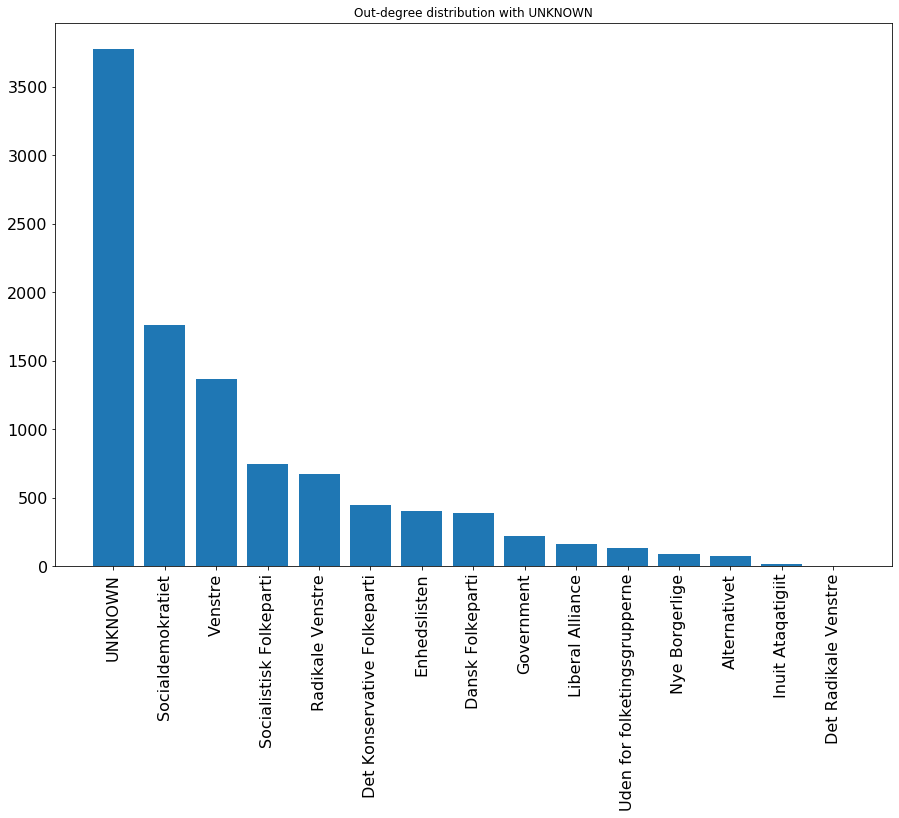

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.subplots(figsize=(15,10))

plt.tick_params(labelsize=16)
plt.xticks(rotation=90)
plt.bar(tweet_out_count.keys(), tweet_out_count.values())
plt.title("Out-degree distribution with UNKNOWN")
plt.show()

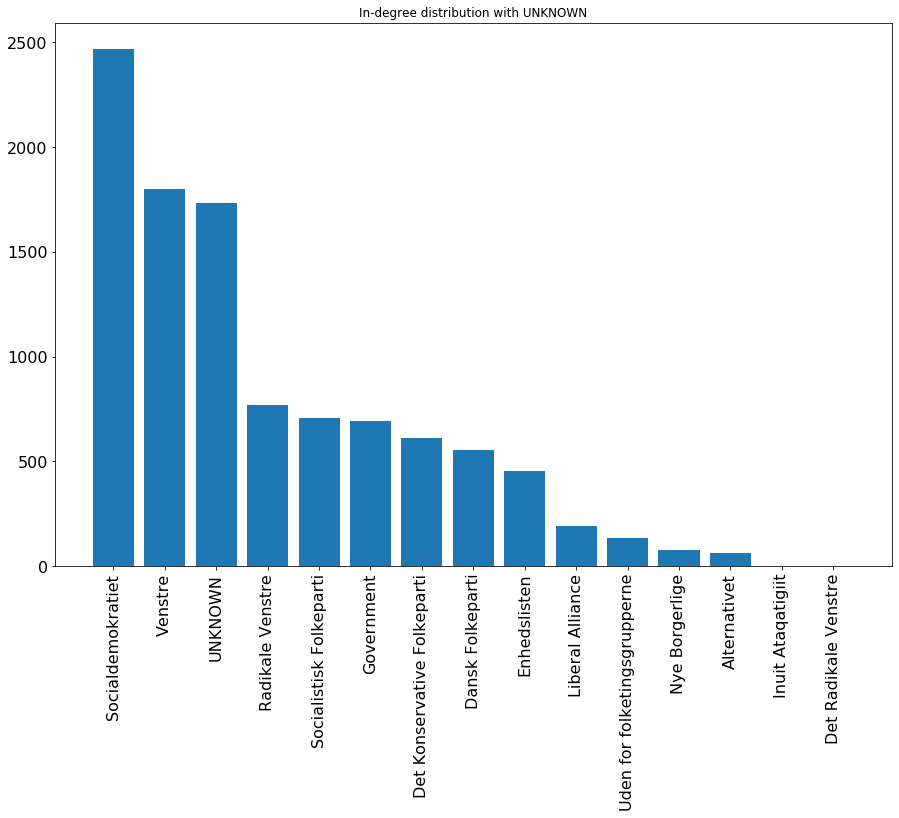

In [16]:
fig = plt.subplots(figsize=(15,10))

plt.tick_params(labelsize=16)
plt.xticks(rotation=90)
plt.bar(tweet_to_count.keys(), tweet_to_count.values())
plt.title("In-degree distribution with UNKNOWN")

plt.show()

## Without unknowns

In [17]:

tweet_to_count_clean = tweet_to_count.copy()
tweet_out_count_clean = tweet_out_count.copy()

tweet_to_count_clean.pop('UNKNOWN')
tweet_out_count_clean.pop('UNKNOWN')


3778

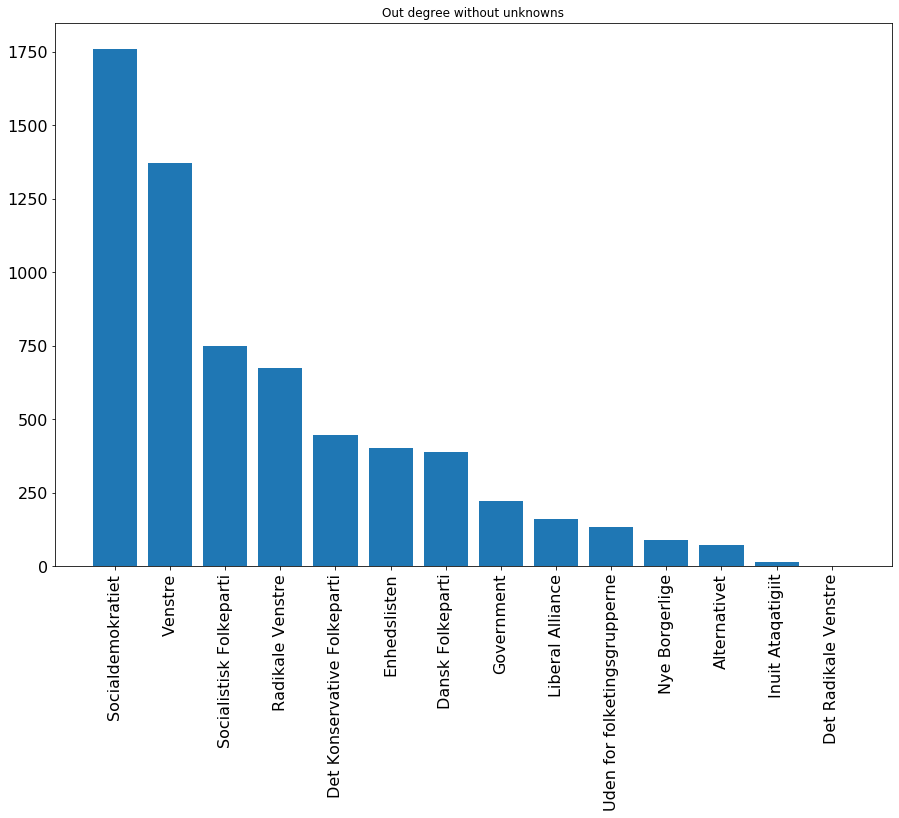

In [18]:
fig = plt.subplots(figsize=(15,10))

plt.tick_params(labelsize=16)
plt.xticks(rotation=90)
plt.bar(tweet_out_count_clean.keys(), tweet_out_count_clean.values())
plt.title("Out degree without unknowns")
plt.show()


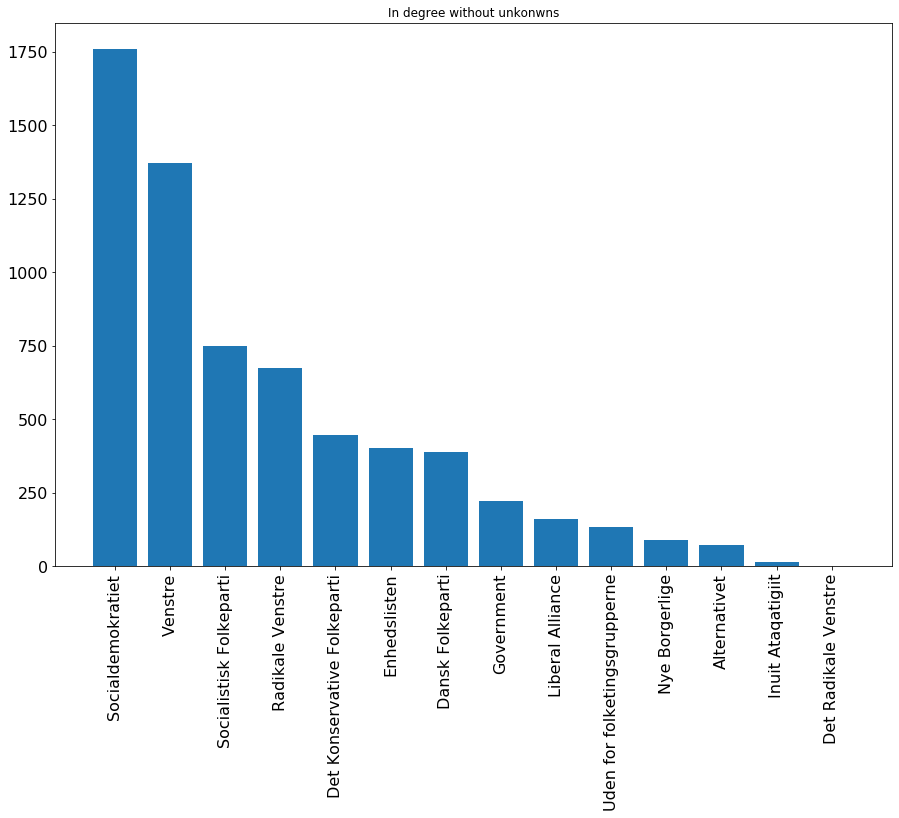

In [19]:

fig = plt.subplots(figsize=(15,10))

plt.tick_params(labelsize=16)
plt.xticks(rotation=90)
plt.bar(tweet_out_count_clean.keys(), tweet_out_count_clean.values())
plt.title("In degree without unkonwns")
plt.show()

## Getting average as the amount of policians isn't at all evenly distributed

In [20]:
vals = nx.get_node_attributes(G, "party").values()
sum_party =dict.fromkeys(tweet_out_count.keys(),0)
for party_occ in vals:
    sum_party[party_occ] += 1
sum_party

avg_tweet_out = dict.fromkeys(tweet_out_count.keys())
avg_tweet_in= dict.fromkeys(tweet_to_count.keys())

for key in tweet_out_count:
    avg_tweet_out[key] = tweet_out_count[key] / sum_party[key]
    avg_tweet_in[key] = tweet_to_count[key] / sum_party[key]
    
ang_tweet_out = dict(sorted(avg_tweet_out.items(), key=lambda item: item[1],reverse=True))
avg_tweet_in = dict(sorted(avg_tweet_in.items(), key=lambda item: item[1],reverse=True))


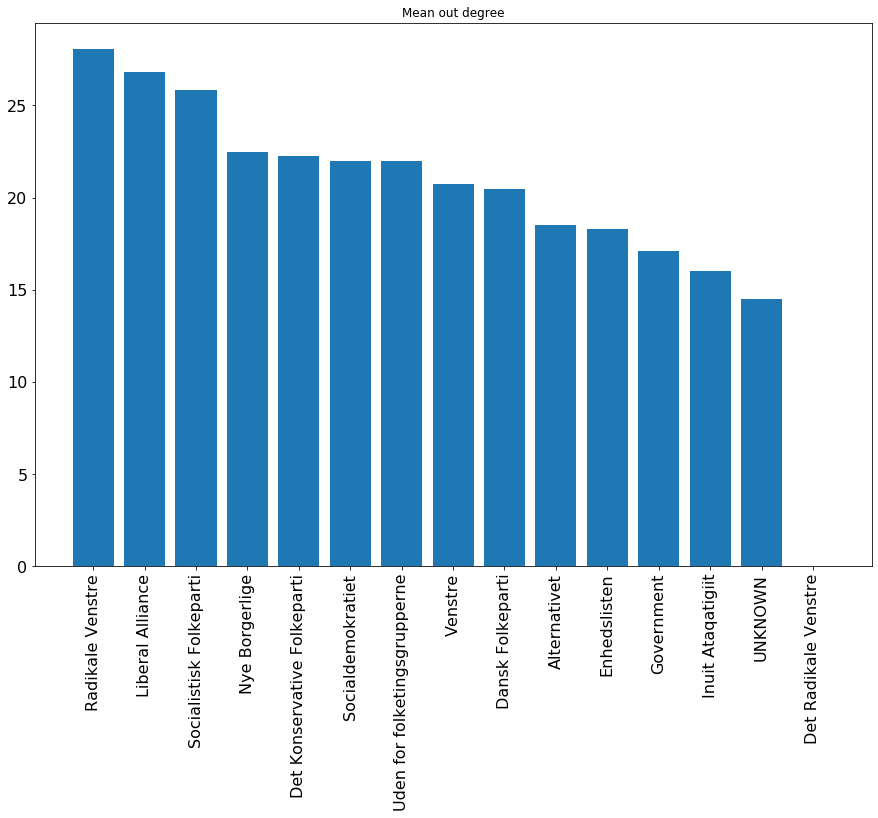

In [21]:
#ax = plt.subplot(111)

#x = pd.DataFrame([avg_tweet_in])
#chart =sns.barplot(x="day", y="total_bill",data=x)
#chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
#plt.show()
fig = plt.subplots(figsize=(15,10))

plt.tick_params(labelsize=16)
plt.xticks(rotation=90)
plt.bar(ang_tweet_out.keys(), ang_tweet_out.values())
plt.title("Mean out degree")
plt.show()

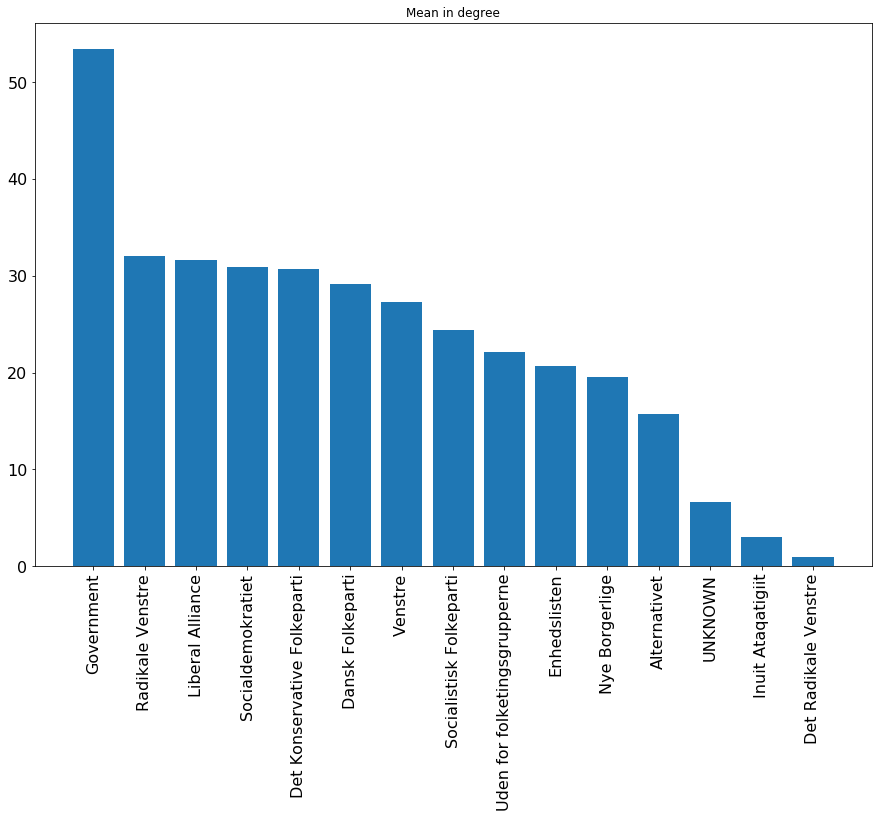

In [22]:
fig = plt.subplots(figsize=(15,10))

plt.tick_params(labelsize=16)
plt.xticks(rotation=90)
plt.bar(avg_tweet_in.keys(), avg_tweet_in.values())
plt.title("Mean in degree")
plt.show()

## Graph visualization

In [23]:
Gcc = sorted(nx.weakly_connected_components(G), key=len, reverse=True)

giant = G.subgraph(Gcc[0])
giant = giant.to_undirected()



for node in list(giant.nodes()):
    if (giant.degree(node) <= 2):
        giant.remove_node(node)

parties = list(nx.get_node_attributes(giant,'party').values())
color_map = []
d = dict(giant.degree) #degrees for every node

#Making color list
for i in range(len(parties)): #for all nodes
    if parties[i] == 'Socialdemokratiet':
        color_map.append('red')
    elif parties[i] == 'Venstre':
        color_map.append('blue')
        
    elif parties[i]=='Dansk Folkeparti':
        color_map.append('pink')
        
    elif parties[i]=='Socialistisk Folkeparti':
        color_map.append('brown')
        
    elif parties[i] == 'Radikale Venstre':
        color_map.append('#1f78b4')
        
    elif parties[i] == 'Enhedslisten':
        color_map.append('#D0004D')
        
    elif parties[i] == 'Det Konservative Folkeparti':
        color_map.append('#00583C')
        
    elif parties[i] == 'Nye Borgerlige':
        color_map.append('#235d66')
    elif parties[i] == 'Liberal Alliance':
        color_map.append('orange')
    elif parties[i] == 'Alternativet':
        color_map.append('yellow')
    elif parties[i] == 'Government':
        color_map.append('black')
    else:
        color_map.append('white')

100%|██████████| 2000/2000 [00:19<00:00, 100.21it/s]


BarnesHut Approximation  took  1.95  seconds
Repulsion forces  took  17.07  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.23  seconds
AdjustSpeedAndApplyForces step  took  0.37  seconds


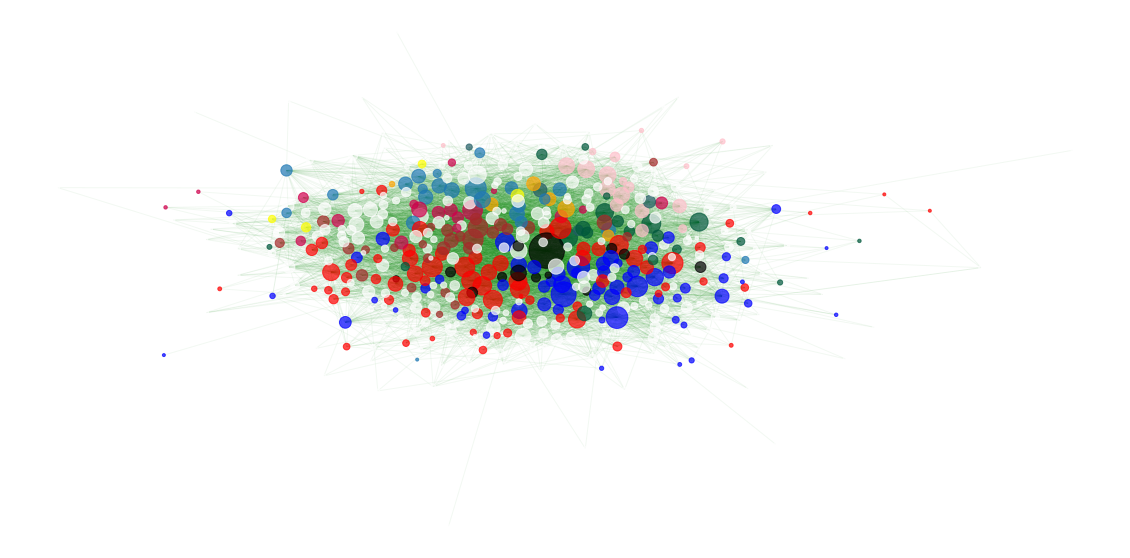

In [24]:
from fa2 import ForceAtlas2

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs   #Want hubs inside other!
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=True,
                        gravity=1.0,

                        # Log
                        verbose=True)


positions = forceatlas2.forceatlas2_networkx_layout(giant, pos=None, iterations=2000)

plt.figure(figsize=(20,10))
nx.draw_networkx_nodes(giant, positions, node_color=color_map, alpha=0.7,node_size=[v * 3 for v in d.values()])
nx.draw_networkx_edges(giant, positions, edge_color="green", alpha=0.05)
plt.axis('off')
plt.show()

## Observations
The graph is quite compact, with many large blue and red nodes which makes sense, as these are the biggest parties in denmark; namely "Venstre" and "Socialdemokratiet". Furthermore, there are large black nodes that are central in the network - this also makes sense as we've marked government entities as black. However there are still some problems with the visualization that we want to solve.


# Segregating into red block vs blue block

The problem with the network visualization is that we have too many different parties and getting a nice visualization becomes difficult. Bloc politics refers to the act of parties uniting in order to gain a majority vote over the parliament. In danish politics, according to https://da.wikipedia.org/wiki/Blokpolitik we have 3 blocs, red blue and green. We will segregate our parties into this by adding a graph attribute "bloc" .

In [25]:
red_bloc = ['Socialdemokratiet', 'Enhedslisten', 'Socialistisk Folkeparti', 'Radikale Venstre']
blue_bloc = ['Venstre', 'Dansk Folkeparty', 'Det Konservative Folkeparti', 'Liberal Alliance', 'Nye Borgerlige', 'Fremad']
green_bloc = ['Alternativet']
    
    
for key, val in dict_of_attributes.items():
    print(key)
    if val['party'] in red_bloc:
        val['block'] = 'red'
    elif val['party'] in blue_bloc:
        val['block'] = 'blue'
    elif val['party'] in green_bloc:
        val['block'] = 'green'
    elif val['party'] == 'Government':
        val['block'] = 'black'
    else: 
        val['block'] = 'white' # white node means unknown
        
nx.set_node_attributes(G, dict_of_attributes)

Gcc = sorted(nx.weakly_connected_components(G), key=len, reverse=True)

giant = G.subgraph(Gcc[0])
giant = giant.to_undirected()
d = dict(giant.degree) #degrees for every node

for node in list(giant.nodes()):
    if (giant.degree(node) <= 2):
        giant.remove_node(node)

block_color_map = list(nx.get_node_attributes(giant, 'block').values())
print(block_color_map)

vestager
SchaldemoseMEP
karmel80
oestergaard
sofiecn
simonkollerup
jesper_bedreby
RohlChristopher
larsloekke
Statsmin
_MaiMercado
JakobEllemann
SorenPape
RasmusJarlov
BjBrandenborg
Kristianthdahl
Jesper_Pet
rasmusnordqvist
FrankJensenKBH
LouiseElholm
JanEJoergensen
RStoklund
regeringDK
LotteRod
aahlers
PiaOlsen
signe_munk
PSkipperEL
MaiVilladsen
rubenkidde
DanJoergensen
NWammen
FrkCallesen
SamiraNawa
a_steenberg
stinuslindgreen
karinFbach
KatrineRobsoe
martinlidegaard
metteabildgaard
olebirkolesen
Hans_Kr_Skibby
LeaWermelin
mortenhelveg
Joymogensen
SandKjaer
orlaosterby
Sten_Knuth
BirgitteBergman
brittbager
zeniastampe
JeppeBruus
mattiastesfaye
RosenkrantzT
KHegaard
krarup_lars
Pia_Kjaersgaard
pederhvelplund
MogensJensenS
RosaLundEl
EvaFlyvholm
JakobSoelvhoej
AndersKronborg
nvillumsen
StemLAURITZEN
mfMorten
RuneLundEL
Heunicke
karinaehl
Danielpanduro
mariagudme
PHummelgaard
VictoriaRV
uffeelbaek
IdaAuken
Paulin_Anne
larsgaardhoj
skaarup_df
MargreteAuken
ammitzbollbille
MrMesserschmidt


100%|██████████| 2000/2000 [00:21<00:00, 94.46it/s] 


BarnesHut Approximation  took  2.02  seconds
Repulsion forces  took  18.25  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.20  seconds
AdjustSpeedAndApplyForces step  took  0.37  seconds


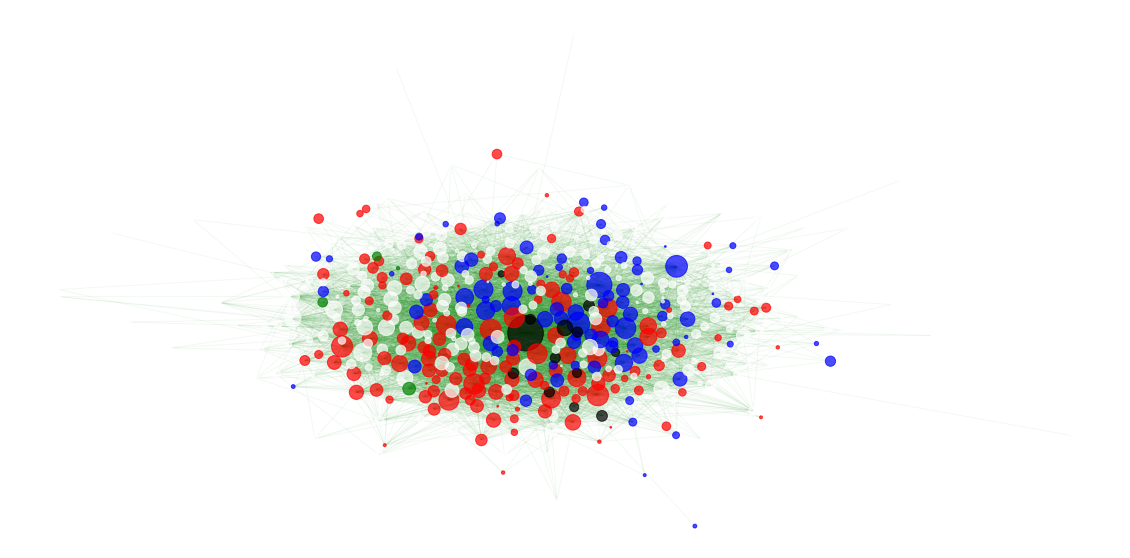

In [26]:
from fa2 import ForceAtlas2

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs   #Want hubs inside other!
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=True,
                        gravity=1.0,

                        # Log
                        verbose=True)


positions = forceatlas2.forceatlas2_networkx_layout(giant, pos=None, iterations=2000)

plt.figure(figsize=(20,10))
nx.draw_networkx_nodes(giant, positions, node_color=block_color_map, alpha=0.7,node_size=[v * 3 for v in d.values()])
nx.draw_networkx_edges(giant, positions, edge_color="green", alpha=0.05)
plt.axis('off')
plt.show()

Now we can observe some seperation between the red and blue blocs, with government entities in the middle (black nodes)

Let's try to eliminate the white ('UNKNOWNS')

In [27]:
for node in list(giant.nodes(data=True)):
    if (node[1]['block'] == 'white'):
        giant.remove_node(node[0])
block_color_map = list(nx.get_node_attributes(giant, 'block').values())
d = dict(giant.degree) #degrees for every node

print(block_color_map)

['red', 'red', 'red', 'red', 'red', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'red', 'red', 'red', 'blue', 'blue', 'red', 'black', 'red', 'blue', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'blue', 'blue', 'red', 'red', 'red', 'blue', 'blue', 'blue', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'blue', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'blue', 'blue', 'blue', 'red', 'blue', 'blue', 'blue', 'blue', 'blue', 'red', 'red', 'blue', 'blue', 'red', 'red', 'red', 'red', 'red', 'red', 'blue', 'red', 'black', 'black', 'blue', 'blue', 'red', 'blue', 'red', 'blue', 'red', 'blue', 'red', 'red', 'blue', 'red', 'red', 'blue', 'green', 'red', 'red', 'red', 'red', 'red', 'red', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'red', 'black', 'black', 'blue', 'blue', 'blue', 'red', 'red', 'blue', 'red', 'blue', 'red', 'red', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue'

100%|██████████| 2000/2000 [00:06<00:00, 310.79it/s]


BarnesHut Approximation  took  0.73  seconds
Repulsion forces  took  5.32  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.09  seconds
AdjustSpeedAndApplyForces step  took  0.17  seconds


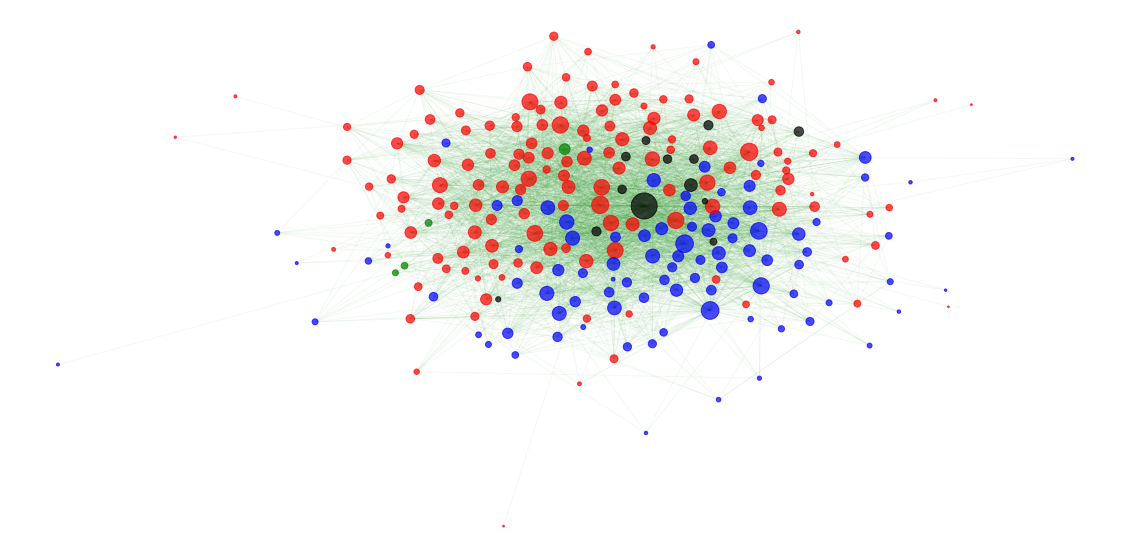

In [28]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs   #Want hubs inside other!
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=True,
                        gravity=1.0,

                        # Log
                        verbose=True)


positions = forceatlas2.forceatlas2_networkx_layout(giant, pos=None, iterations=2000)

plt.figure(figsize=(20,10))
nx.draw_networkx_nodes(giant, positions, node_color=block_color_map, alpha=0.7,node_size=[v * 3 for v in d.values()])
nx.draw_networkx_edges(giant, positions, edge_color="green", alpha=0.05)
plt.axis('off')
plt.show()

The network looks a bit neater, but we can observe that the large central government profiles have decreased in degree, signalling that a lot of the unknowns have tweeted to that profile. Interestingly, the few green block nodes are leaning to the right. Now we will look at sentiment of tweets, that link 2 profiles.

### Sentiment

In [29]:
#!pip install afinn
#!pip install langdetect

from langdetect import detect

#from textblob import TextBlob
from afinn import Afinn
afinn = Afinn()
afinn_da = Afinn(language='da')


        
print(afinn.score('Test bad bad booo hate'))
print(afinn.score('er'))

-9.0
0.0


In [99]:
with open('tweet_dict_listversion_wrealnames_v2.data', 'rb') as filehandle:
    tweet_dict = pickle.load(filehandle) 
    



In [100]:
# helper function
def get_party(node):
    # returns party of a node
    x = data.loc[data['Twittername'] == node]    
    for w in x['Party']:
        return w
    #return x['Party'][0]



In [101]:
total_sentiment = dict.fromkeys(unique_parties)
for key, value in total_sentiment.items():
    total_sentiment[key] = { i : {'scores':[], 'mean': 0} for i in unique_parties }

#total_sentiment

In [102]:
# for each tweet calculate a score 
# get from party and to party
# update total
count = 0

for key,value in tqdm(tweet_dict.items()):
    #print(key)
    from_party = get_party(key)
    for mention, texts in value.items():
        to_party = get_party(mention)
        for tweet in texts:
            # remove @s
            tweet = re.sub(r'@\w+\b', '', tweet)
            tweet = tweet.strip()
            try:
                lang = detect(tweet)
            except Exception as e:
                print(e)
                print("tweet = " + tweet)
                continue # skip
            if lang == 'da' or lang == 'no':
                score = afinn_da.score(tweet)
            elif lang == 'en':
                score = afinn.score(tweet)
            else:
                score = afinn_da.score(tweet)
                print(tweet)
                print("Language    " + lang)
                print("debug: " + str(afinn_da.score(tweet)))
                continue

            try:
                total_sentiment[from_party][to_party]['scores'].append(score)
            except Exception as e:
                print("Error" + str(e))
                print("Backlog: ")
                print("tweet from "  + key + " to " + mention)



Men du fik din historie alligevel. Skam dig! https://t.co/cPD6ZmMAg9
Language    af
debug: 0.0
RT :  Flot grøn alliance , , , ,  , 

Vil …
Language    it
debug: 3.0
RT :  Flot grøn alliance , , , ,  , 

Vil …
Language    it
debug: 3.0
Enig
Language    de
debug: 1.0
Nej
Language    sk
debug: -1.0
Nej
Language    sk
debug: -1.0
Hurra 🙏🙏🙏
Language    es
debug: 5.0
Mega god stil. Tak  https://t.co/AnQMDdi9xb
Language    sl
debug: 5.0
God bedring
Language    cy
debug: 3.0
Hvad mener du?
Language    fr
debug: 0.0
Hvad mener du?
Language    nl
debug: 0.0
Tak
Language    sw
debug: 2.0
No features in text.
tweet = 👍
No features in text.
tweet = 🙏😊
No features in text.
tweet = 👊
No features in text.
tweet = 😂😂😂
No features in text.
tweet = 😂😂😂
Puha 🤞
Language    id
debug: 0.0
No features in text.
tweet = 👊
Nemlig
Language    sv
debug: 0.0
Flot!
Language    sv
debug: 3.0
No features in text.
tweet = 👍
No features in text.
tweet = 🙏😊
No features in text.
tweet = 👍
No features in text.
tweet = 🙏😊
N

Juhuu!! 💪🏼
Language    sw
debug: 0.0
No features in text.
tweet = https://t.co/5DN3xK6ub5
ErrorNone
Backlog: 
tweet from mortenhelveg to AsgerChristens2
RT : https://t.co/x1bCqRQRR8  #dkpol
Language    sl
debug: 0.0
Ja!
Language    sw
debug: 1.0
Tak 😊
Language    id
debug: 2.0
Ja præcis 😋
Language    pt
debug: 3.0
No features in text.
tweet = 💛💙💛💙
*NC3
Language    vi
debug: 0.0
*NC3
Language    vi
debug: 0.0
*NC3
Language    vi
debug: 0.0
Mange tak Uffe🙏🏼
Language    id
debug: 2.0
RT : #dkpol  https://t.co/uMePeKj0Cf
Language    sk
debug: 0.0
Mange tak Uffe🙏🏼
Language    id
debug: 2.0
Mange tak Uffe🙏🏼
Language    id
debug: 2.0
No features in text.
tweet = https://t.co/UYC7WqHulv
Fra de to partiers mund
Language    es
debug: 0.0
Enig Michael!
Language    cy
debug: 1.0
Done!
Language    it
debug: 0.0
Dét er public service Jens👏🏻👏🏻
Language    fr
debug: 0.0
No features in text.
tweet = 👏🏻👏🏻
RT : #dkpol  https://t.co/uMePeKj0Cf
Language    sk
debug: 0.0
No features in text.
tweet = 🙏
No fe

ErrorNone
Backlog: 
tweet from MFVMin to MogensJensenS
ErrorNone
Backlog: 
tweet from MFVMin to MogensJensenS
ErrorNone
Backlog: 
tweet from MFVMin to MogensJensenS
ErrorNone
Backlog: 
tweet from MFVMin to MogensJensenS
ErrorNone
Backlog: 
tweet from MFVMin to MogensJensenS
ErrorNone
Backlog: 
tweet from MFVMin to MogensJensenS
ErrorNone
Backlog: 
tweet from MFVMin to MogensJensenS
ErrorNone
Backlog: 
tweet from MFVMin to MogensJensenS
ErrorNone
Backlog: 
tweet from MFVMin to MogensJensenS
ErrorNone
Backlog: 
tweet from MFVMin to MogensJensenS
ErrorNone
Backlog: 
tweet from MFVMin to MogensJensenS
ErrorNone
Backlog: 
tweet from MFVMin to MogensJensenS
ErrorNone
Backlog: 
tweet from MFVMin to MogensJensenS
ErrorNone
Backlog: 
tweet from MFVMin to MogensJensenS
ErrorNone
Backlog: 
tweet from MFVMin to MogensJensenS
ErrorNone
Backlog: 
tweet from MFVMin to LeaWermelin
ErrorNone
Backlog: 
tweet from MFVMin to LeaWermelin
ErrorNone
Backlog: 
tweet from MFVMin to LeaWermelin
ErrorNone
Backlo

No features in text.
tweet = 🤯
Ping  😉
Language    tl
debug: 0.0
Wauw 😱
Language    sw
debug: 0.0
Jaaaaa!
Language    so
debug: 0.0
ErrorNone
Backlog: 
tweet from EPiDanmark to AsgerChristens2
ErrorNone
Backlog: 
tweet from EPiDanmark to AsgerChristens2
ErrorNone
Backlog: 
tweet from EPiDanmark to AsgerChristens2
ErrorNone
Backlog: 
tweet from EPiDanmark to AsgerChristens2
ErrorNone
Backlog: 
tweet from EPiDanmark to AsgerChristens2
ErrorNone
Backlog: 
tweet from EPiDanmark to AsgerChristens2
No features in text.
tweet = 😬
. : Vielen Dank an  und  sowie an meine europäischen Kolleginnen+Kollegen für die guten Gespräche in #Berlin. Der enge Austausch zur aktuellen Lage sowie zur gemeinsamen Sicherheits- und Verteidungspolitik &amp; #StrategicCompass ist wichtig #dkpol https://t.co/qNbDYyjQLA
Language    de
debug: 0.0
ErrorNone
Backlog: 
tweet from KlimaMin to MFVMin
ErrorNone
Backlog: 
tweet from KlimaMin to MFVMin
ErrorNone
Backlog: 
tweet from KlimaMin to MFVMin
No features in text.
t

RT :   Ha ha ... genialt !
Language    nl
debug: 7.0
No features in text.
tweet = 😂
No features in text.
tweet = 🤐
RT : Thomas har en pointe - Hvad vidste statsministeren? #dkpol
Language    sv
debug: 0.0
RT :   Ha ha ... genialt !
Language    nl
debug: 7.0
No features in text.
tweet = 🤐
No features in text.
tweet = 🤐
No features in text.
tweet = 🤐
No features in text.
tweet = 🤐
RT :   Ha ha ... genialt !
Language    nl
debug: 7.0
RT : Tak til        👍🏻 #d…
Language    id
debug: 2.0
RT : Tak til        👍🏻 #d…
Language    id
debug: 2.0
RT : Tak til        👍🏻 #d…
Language    id
debug: 2.0
RT : Tak til        👍🏻 #d…
Language    id
debug: 2.0
RT : Tak til        👍🏻 #d…
Language    id
debug: 2.0
RT : Tak til        👍🏻 #d…
Language    id
debug: 2.0
RT : Tak til        👍🏻 #d…
Language    id
debug: 2.0
Nej!
Language    sk
debug: -1.0
God stil💙🙏
Language    hr
debug: 3.0
God stil💙🙏
Language    hr
debug: 3.0
Fokus....
Language    fi
debug: 0.0
RT : Boomerang! https://t.co/hymocQliJj
Language    

Godt valg ☺️👍🏻
Language    af
debug: 3.0
No features in text.
tweet = 🤗
No features in text.
tweet = 🤗
Enig!
Language    tl
debug: 1.0
God bedring
Language    cy
debug: 3.0
Tak Susanne!
Language    id
debug: 2.0
Tak Martin 🙏🏼
Language    id
debug: 2.0
No features in text.
tweet = 😄😉💚
Tak Susanne!
Language    id
debug: 2.0
Tak Martin 🙏🏼
Language    id
debug: 2.0
Tak Jonas. Vi er klar til en en stor klimamarathon i efteråret.
Language    sv
debug: 3.0
Tak Jonas. Vi er klar til en en stor klimamarathon i efteråret.
Language    sv
debug: 3.0
No features in text.
tweet = https://t.co/2xZjWzXHic
No features in text.
tweet = https://t.co/c59PVi8xQs
Tillykke👍
Language    fi
debug: 2.0
No features in text.
tweet = 
No features in text.
tweet = https://t.co/VCrQAmkFiq
VLTJ?
Language    et
debug: 0.0
Tillykke Kaare 👍
Language    af
debug: 2.0
No features in text.
tweet = https://t.co/F7855bSHcP
Tak Kristian🥰
Language    id
debug: 2.0
Sejt!
Language    sq
debug: 0.0
ErrorNone
Backlog: 
tweet from 

Flot    ❤️ https://t.co/VEhNK8m6jV
Language    sv
debug: 3.0
Flot    ❤️ https://t.co/VEhNK8m6jV
Language    sv
debug: 3.0
Serr?
Language    de
debug: 0.0
Flot Mona 🙏🏻😄🙌
Language    ca
debug: 3.0
Tillykke
Language    fi
debug: 2.0
Tak
Language    sw
debug: 2.0
ErrorNone
Backlog: 
tweet from clausjorgensen to MFVMin
ErrorNone
Backlog: 
tweet from clausjorgensen to MFVMin
ErrorNone
Backlog: 
tweet from clausjorgensen to MFVMin
ErrorNone
Backlog: 
tweet from clausjorgensen to MFVMin
ErrorNone
Backlog: 
tweet from clausjorgensen to MFVMin
God bedring 💚
Language    cy
debug: 3.0
No features in text.
tweet = https://t.co/X165zoeFg9
Tak! ☺️
Language    id
debug: 2.0
Mange tak,  ! ☺️
Language    id
debug: 2.0
Selv tak! ♥️
Language    hu
debug: 2.0
Selv tak! 🙏🏻
Language    hu
debug: 2.0
Tak! ☺️
Language    id
debug: 2.0
Tak! 👏🏻
Language    id
debug: 2.0
Selv tak! 👏🏻🔥
Language    hu
debug: 2.0
Tak  ! ☺️👌🏻
Language    id
debug: 2.0
No features in text.
tweet = https://t.co/X165zoeFg9
Hvor får man 

ErrorNone
Backlog: 
tweet from AsgerChristens2 to LeaWermelin
ErrorNone
Backlog: 
tweet from AsgerChristens2 to LeaWermelin
ErrorNone
Backlog: 
tweet from AsgerChristens2 to LeaWermelin
ErrorNone
Backlog: 
tweet from AsgerChristens2 to LeaWermelin
ErrorNone
Backlog: 
tweet from AsgerChristens2 to jacobjensenMF
ErrorNone
Backlog: 
tweet from AsgerChristens2 to Pia_Kjaersgaard
ErrorNone
Backlog: 
tweet from AsgerChristens2 to JakobEllemann
ErrorNone
Backlog: 
tweet from AsgerChristens2 to JakobEllemann
ErrorNone
Backlog: 
tweet from AsgerChristens2 to JakobEllemann
ErrorNone
Backlog: 
tweet from AsgerChristens2 to JakobEllemann
ErrorNone
Backlog: 
tweet from AsgerChristens2 to larsloekke
ErrorNone
Backlog: 
tweet from AsgerChristens2 to larsloekke
ErrorNone
Backlog: 
tweet from AsgerChristens2 to larsloekke
ErrorNone
Backlog: 
tweet from AsgerChristens2 to EllenTraneNorby
ErrorNone
Backlog: 
tweet from AsgerChristens2 to EllenTraneNorby
ErrorNone
Backlog: 
tweet from AsgerChristens2 to E

No features in text.
tweet = 😀
No features in text.
tweet = https://t.co/Cw1KwQCxrH
ErrorNone
Backlog: 
tweet from HanneRoed to MFVMin
Og aktie-kongen
Language    af
debug: 0.0
ErrorNone
Backlog: 
tweet from AllanAhmadDK to SassLarsen
Sejt Steen 👍☘️🌹
Language    fi
debug: 0.0
No features in text.
tweet = 😉
RT : 25 mia!! https://t.co/4aYrEBlzfP
Language    sw
debug: 0.0
Tak Kim 👍
Language    sw
debug: 2.0
RT :  at #Schulbau Hamburg about https://t.co/KLZlFKh9Az https://t.co/u4oZFg1rEx
Language    de
debug: 0.0
No features in text.
tweet = https://t.co/Fr6TDC1Osq
Hvad så?
Language    sv
debug: 0.0
Tak 🙏🏻
Language    id
debug: 2.0
No features in text.
tweet = https://t.co/VrsKnBu1N6
No features in text.
tweet = https://t.co/2SLPHgLjnX
ErrorNone
Backlog: 
tweet from FlemmingDL to SassLarsen
ErrorNone
Backlog: 
tweet from orlaosterby to MFVMin
Tak Pia :)
Language    tl
debug: 2.0
Tak Sofie :)
Language    af
debug: 2.0
ja du får den Lone, du har ret. :)
Language    fr
debug: 1.0
ja du får de

Tak👍
Language    sw
debug: 2.0
RT : https://t.co/KcdheNJLvC #dkpol #dkgreen
Language    af
debug: 0.0
No features in text.
tweet = 😄
RT :        5/  fra : 
- Al…
Language    ca
debug: 0.0
RT :        5/  fra : 
- Al…
Language    ca
debug: 0.0
RT :        5/  fra : 
- Al…
Language    ca
debug: 0.0
Helt enig!
Language    nl
debug: 1.0
ErrorNone
Backlog: 
tweet from janwammen to SassLarsen
Jo
Language    pt
debug: 0.0
No features in text.
tweet = https://t.co/E25gP0f8B2
Godt Mia!
Language    de
debug: 3.0
Godt Mia!
Language    de
debug: 3.0
Ok fair nok
Language    lv
debug: 0.0
godt mia!
Language    pl
debug: 3.0
ok fair nok
Language    lv
debug: 0.0
Hovsa, Per - det var faktisk 10,5 mio.!
Language    sv
debug: 0.0
No features in text.
tweet = https://t.co/Zw4YnbTGvc
Simon er Thybo, vi drikker naturligvis Thy Pilsner ;) God weekend :)
Language    af
debug: 3.0
RT : No, no, noooooo. #dkpol https://t.co/cXuPLK15nT
Language    so
debug: 0.0
Helt enig!
Language    nl
debug: 1.0
I blame you Pe

ErrorNone
Backlog: 
tweet from Martin_geertsen to Torstenschack
ErrorNone
Backlog: 
tweet from Martin_geertsen to jacobjensenMF
ErrorNone
Backlog: 
tweet from Martin_geertsen to stephanie_lose
ErrorNone
Backlog: 
tweet from Martin_geertsen to larsloekke
ErrorNone
Backlog: 
tweet from Martin_geertsen to larsloekke
ErrorNone
Backlog: 
tweet from Martin_geertsen to jensmandrup
ErrorNone
Backlog: 
tweet from Martin_geertsen to KarolineVind
ErrorNone
Backlog: 
tweet from Martin_geertsen to karinFbach
ErrorNone
Backlog: 
tweet from Martin_geertsen to Kristian_Jensen
ErrorNone
Backlog: 
tweet from Martin_geertsen to krarup_lars
ErrorNone
Backlog: 
tweet from Martin_geertsen to Joymogensen
ErrorNone
Backlog: 
tweet from Martin_geertsen to Joymogensen
ErrorNone
Backlog: 
tweet from Martin_geertsen to madsfuglede
ErrorNone
Backlog: 
tweet from Martin_geertsen to JaneHeitmann
ErrorNone
Backlog: 
tweet from Martin_geertsen to JaneHeitmann
ErrorNone
Backlog: 
tweet from Martin_geertsen to JaneHeitm

In [42]:
def isNaN(num):
    return num != num

In [43]:
for f, _to in total_sentiment.items():
    for key in _to.keys():
        mean = np.nanmean(total_sentiment[f][key]['scores'])
        # when no mentions to a party set default 0
        if isNaN(mean):
            mean = 0
        total_sentiment[f][key]['mean'] = mean

C:\Users\Christian\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


In [44]:
for key, value in total_sentiment.items():
    sorted_list = sorted(value.items(), key=lambda k_v: k_v[1]['mean'])
    #print(sorted_list)
    sorted_list.reverse()
    print(key + " is most positive regarding " +  str(sorted_list[0][0]) + ":"+ str(sorted_list[0][1]['mean']))

Dansk Folkeparti is most positive regarding Det Konservative Folkeparti:1.3021582733812949
Radikale Venstre is most positive regarding Inuit Ataqatigiit:8.0
Alternativet is most positive regarding Radikale Venstre:3.3
Uden for folketingsgrupperne is most positive regarding Nye Borgerlige:3.0
Government is most positive regarding Socialistisk Folkeparti:1.9375
Socialistisk Folkeparti is most positive regarding UNKNOWN:1.0769230769230769
Enhedslisten is most positive regarding Dansk Folkeparti:0.95
Det Konservative Folkeparti is most positive regarding Venstre:1.525
Socialdemokratiet is most positive regarding Det Radikale Venstre:3.0
Det Radikale Venstre is most positive regarding UNKNOWN:0
Nye Borgerlige is most positive regarding Venstre:1.4090909090909092
Venstre is most positive regarding Radikale Venstre:2.0251798561151078
Liberal Alliance is most positive regarding Radikale Venstre:1.6176470588235294
Inuit Ataqatigiit is most positive regarding Enhedslisten:3.5
UNKNOWN is most pos

key : Dansk Folkeparti
mean : 0.47510648207532036
std: 0.47840112640801236
min :-0.5973813420621932
max :1.3021582733812949
key : Radikale Venstre
mean : 1.5095787946629238
std: 1.9560275904867088
min :-0.3333333333333333
max :8.0
key : Alternativet
mean : 0.9609461313956736
std: 0.9921159181221666
min :-0.06172839506172839
max :3.3
key : Uden for folketingsgrupperne
mean : 1.0507928305852117
std: 1.1055598491496168
min :-0.3225806451612903
max :3.0
key : Government
mean : 0.8414731295919442
std: 0.7981950018927685
min :-0.5
max :1.9375
key : Socialistisk Folkeparti
mean : 0.5336441227525424
std: 0.47908251520753015
min :-0.7777777777777778
max :1.0769230769230769
key : Enhedslisten
mean : 0.16720907035247345
std: 0.6118699514957514
min :-1.5714285714285714
max :0.95
key : Det Konservative Folkeparti
mean : 0.7440201166819779
std: 0.8015823977905993
min :-1.6
max :1.525
key : Socialdemokratiet
mean : 1.318667700103733
std: 0.7144011619107807
min :0
max :3.0
key : Det Radikale Venstre
m

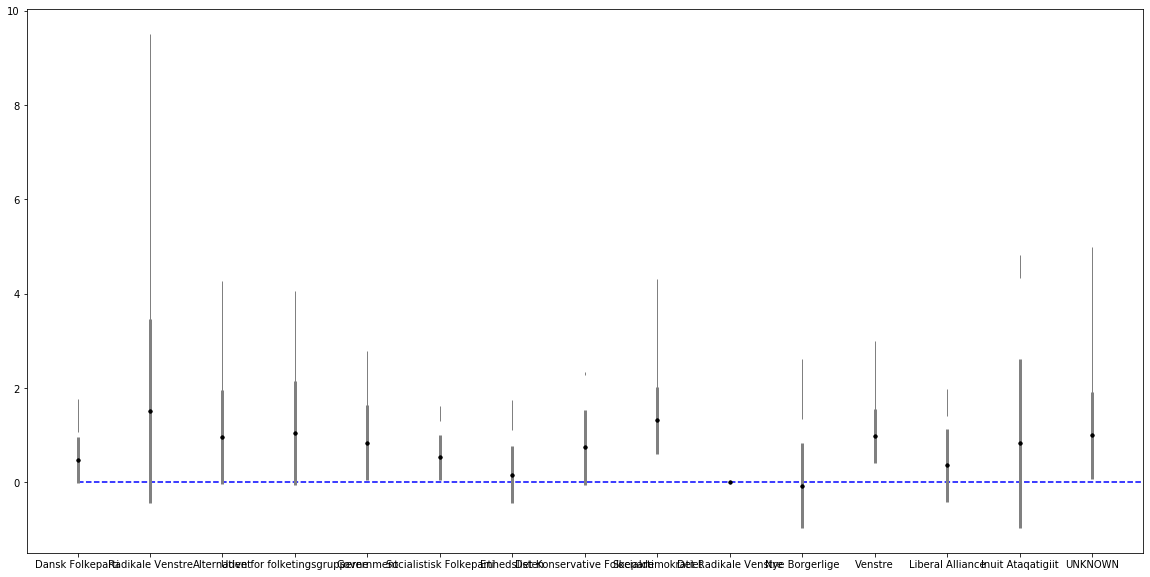

In [98]:
# for each party get statistics 
list_of_means = []
list_of_stds = []
list_of_mins = []
list_of_maxs = []
for key, value in total_sentiment.items():
    print("key : " + key)
    _means = []
    for inner in value.values():
        mean = inner['mean']
        _means.append(mean)
    m = np.nanmean(_means)
    std = np.std(_means)
    minimum = min(_means)
    maximum = max(_means)
    n_bars = len(_means)
    print("mean : "+ str(m))
    print("std: " + str(std))
    print("min :" + str(minimum))
    print("max :" + str(maximum))
    list_of_means.append(m)
    list_of_stds.append(std)
    list_of_mins.append(minimum)
    list_of_maxs.append(maximum)


plt.figure(figsize=(20,10))
plt.hlines(0,0,n_bars,colors='blue', linestyle='dashed')
plt.errorbar(list(total_sentiment.keys()), list_of_means, list_of_stds, fmt='.k', ecolor='gray', lw=3)
plt.errorbar(list(total_sentiment.keys()), list_of_means, [list_of_mins, list_of_maxs],
         fmt='.k', ecolor='gray', lw=1)
plt.show()

